# Integrate datasets with Scanorama


## Description
Use Scanorama to integrate multiple datasets


This notebook was designed to run on Terra, but with a small enough dataset and several tweaks to the code, it should be runnable locally. On Terra, create a custom environment with the image address shaleklab/alxscoregenes:0.21, as few CPUs as possible, anywhere from 8 to 32GB RAM, and 50GB persistent disk space. The RAM you need may need to be much larger depending on the size of the dataset you have.


*Note, this notebook has not yet been tested and on Terra and has only been used on local environments. Additional code to work on Terra has been added but not tested*



## What you should know:

### Alexandria
Alexandria is a single-cell portal and data resource for the global health community. Alexandria will use unified pipelines and interactive notebooks to preprocess, store, and visualize datasets of interest to the global health community, enabling rapid realization of transformative insights and the prioritization of follow-ups. For further information you can visit the [Alexandria Portal](https://singlecell.broadinstitute.org/single_cell?scpbr=the-alexandria-project), the [documentation](https://alexandria-scrna-data-library.readthedocs.io/en/latest/introduction.html), or the [GitHub repository](https://github.com/ShalekLab/alexandria#the-alexandria-project)

### Terra
[Terra.bio](https://terra.bio/) is a scalable research platform for biomedical research that is built upon Google Cloud Platform. Alexandria Notebooks are designed to run upon Terra and similar cloud notebook platforms. Within a Terra workspace, a notebook runtime can be created with custom parameters. It is recommended you use at least 16 GB RAM, 50 GB persistent disk size, and an application configuration which has all the packages and dependencies the notebook requires. You can use the following notebook code chunks to import and export your data. With a [persistent disk](https://support.terra.bio/hc/en-us/articles/360047318551), your data should be retained when the runtime is deleted/recreated. For more information on Terra Notebooks, please see the [Terra documentation](https://support.terra.bio/hc/en-us/sections/360004143932-Visualization-and-Statistics-notebooks-).

### Google Cloud Storage
In a Terra notebook runtime and its associated cloud shell, you should have access to `gsutil`: a commandline tool which can be used to interact with Google Storage buckets and objects. Within the Terra notebook runtime, you must use `gsutil cp` to copy folders/files from a Google Storage endpoint to a destination within the VM. The code cells in the following section will help you move the data. Read more about [gsutil](https://cloud.google.com/storage/docs/gsutil) and [how you can use it with Terra notebooks](https://support.terra.bio/hc/en-us/articles/360024056512-Moving-data-to-from-a-workspace-Google-bucket).

### Scanpy
Scanpy is a scalable toolkit for analyzing single-cell gene expression data. It includes preprocessing, visualization, clustering, trajectory inference and differential expression testing. The Python-based implementation efficiently deals with datasets of more than one million cells. Read more about Scanpy on the [Scanpy documentation](https://scanpy.readthedocs.io/en/stable/).

In [14]:
%matplotlib inline
import matplotlib.pylab as plt
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata
import numpy as np
import scanorama

## Import data
Please edit the below addresses:
* `source_bucket`: The path to the folder on the bucket containing your counts, gene list, metadata, and (optionally) visualization files.
* `destination_vm`: The path on the virtual machine where you wish to send these files for loading into the notebook. The default should suffice.

The files your `source_bucket` folder should contain are:
* `counts`: The cell by gene counts table file
* `cell_metadata`: The cell-level metadata table file.
* *Optional* `viz_coords`: The coordinates file for a UMAP or TSNE visualization.

*See the appendix (bottom-most section) of the notebook to view what these files look like!*

In [ ]:
source_bucket = "gs://fc-secure-ec2ce7e8-339a-47b4-b9d9-34f652cbf41f/data/scoregenes/epi/" # "gs://bucket/path/to/datafolder/"
destination_vm = "/home/jupyter-user/notebooks/data"

source_bucket = source_bucket.rstrip('/') + '/' # Ensure trailing '/'
if not osp.isdir(destination_vm):
    os.makedirs(destination_vm)
command = f"gsutil cp -r {source_bucket} {destination_vm}"
sp.check_call(command.split())
destination_vm = osp.join(destination_vm, osp.basename(osp.dirname(source_bucket)))
print(f"Your files will be found in {destination_vm}")
os.listdir(destination_vm)

## Read data
Your count data may be in a different format than the plain text tab-separated values file listed below. You can visit the [scanpy documentation page on reading](https://scanpy.readthedocs.io/en/stable/api/index.html#reading) to find the function you will need to read the data in as an Anndata object.

It is recommended your cell metadata file conform to the [Alexandria Metadata Convention](https://alexandria-scrna-data-library.readthedocs.io/en/latest/metadata.html) which is compatible with the Alexandria Portal. For this notebook however, your metadata labels can be anything you desire.

In [ ]:
# REQUIRED 
counts_list = {"MCA":"MCA/mca_breast_all.csv","Murrow":"Murrow/murrow_counts.txt.gz"} # add all count matrix filenames, if one study has multiple count matrices, the value should be a list of filenames
cell_metadata_list = {"MCA":"MCA/mca_breast_all_meta.csv","Murrow":"Murrow/murrow_metadata.csv"} # add all metadata names

adatas = {}
for study in counts_list.keys():
    if type(counts_list[study]) == str:
        counts = destination_vm + '/' + counts_list[study]
        adatas[i] = sc.read_csv(counts, delimiter='\t')
        
    else:
        adatas_tmp = []
        for c in counts_list[study]:
            counts = destination_vm + '/' + counts_list[study]
            adata_tmp.append(sc.read_csv(counts,delimiter="\t"))
        adatas[i] = 
    cell_metadata =  destination_vm + '/' + cell_metadata_list[i]

    adatas[i].obs = pd.read_csv(cell_metadata,index_col=0,sep="\t").loc[adata[i].obs_names]
    adatas[i].obs["study"] = study


    


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
# remove not expressed genes
for name,d in adatas.items():
    sc.pp.filter_genes(d, min_cells=10)
    print(name,str(len(d.var_names)))

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


MCA 13705
Murrow 22322
Ngyuen 19992
BM 21215


In [6]:
# count number of datasets containing each gene
varnamelist = [list(i.var_names) for i in adatas.values()]
all_overlaps = pd.DataFrame(index=list(set().union(*varnamelist)), columns=list(adatas.keys()))
for i in all_overlaps.columns:
    all_overlaps.loc[adatas[i].var_names,i] = 1
    
all_overlaps["sum"]=all_overlaps.sum(axis=1)


MCA


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


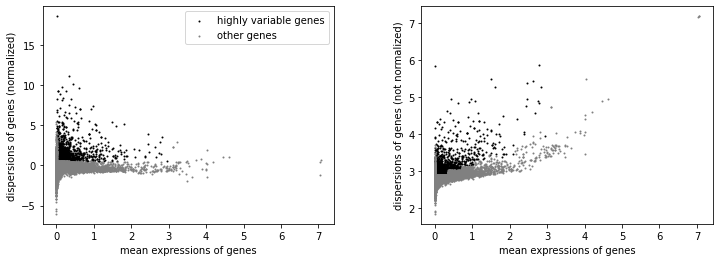

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


2197
Murrow


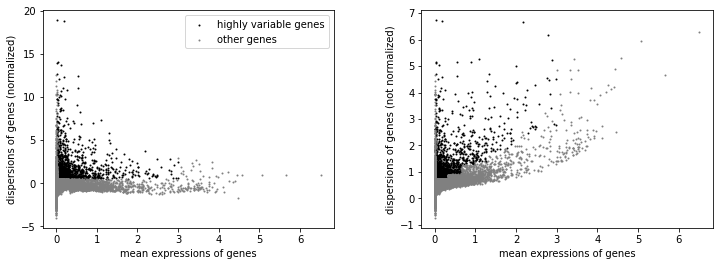

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1791
Ngyuen


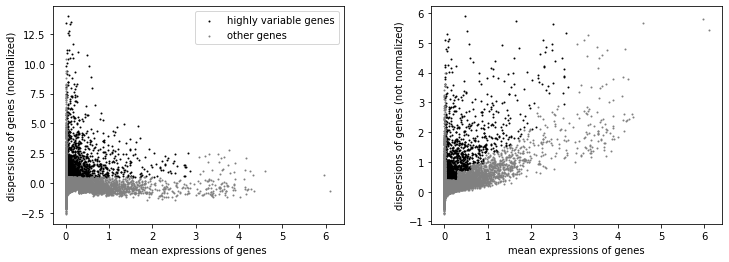

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1571
BM


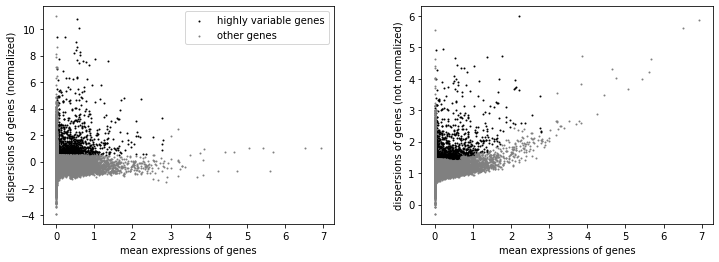

1450


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
normed_data = {}
for name,d in adatas.items():
    print(name)
    all_overlap = all_overlaps.loc[(all_overlaps["sum"]>=2) & (all_overlaps[name] > 0)].index
    d = d[:,list(all_overlap)]
    normed_data[name] = sc.pp.normalize_per_cell(d, counts_per_cell_after=1e4,copy=True)
    sc.pp.log1p(normed_data[name])
    sc.pp.highly_variable_genes(normed_data[name], min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(normed_data[name])
    print(len(normed_data[name][:, normed_data[name].var['highly_variable']].var_names))


In [8]:
genes_of_interest = set()
for i,j in normed_data.items():
    genes_of_interest = genes_of_interest.union(set(j[:, j.var['highly_variable']].var_names))

In [9]:
len(genes_of_interest)

4906

In [11]:
# add in genes that aren't expressed in all datasets
reduced_datasets = {}
for name,d in adatas.items():
    df = pd.DataFrame(d.X, index=d.obs_names, columns=d.var_names)
    
    df=df.reindex(columns=list(genes_of_interest)).squeeze()
    print(df.shape)
    df = df.fillna(0)
    reduced_datasets[name] = anndata.AnnData(df)
    reduced_datasets[name].obs_names = d.obs_names
    reduced_datasets[name].var_names = df.columns
    reduced_datasets[name].obs = d.obs

(28648, 4906)


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


(58083, 4906)
(24465, 4906)
(39825, 4906)


In [12]:
for name,d in reduced_datasets.items():
    sc.pp.log1p(reduced_datasets[name])

In [ ]:
datasets_dimred,new_adatas = scanorama.correct_scanpy(reduced_datasets.values(),return_dimred=True,ds_names=list(reduced_datasets.keys()),alpha=.01)


After MCA: 4906 genes
After Murrow: 4906 genes
After Ngyuen: 4906 genes
After BM: 4906 genes
Found 4906 genes among all datasets
[[0.         0.01322954 0.00397934 0.04447082]
 [0.         0.         0.32103004 0.00363273]
 [0.         0.         0.         0.02125485]
 [0.         0.         0.         0.        ]]
Processing datasets Murrow <=> Ngyuen
Processing datasets MCA <=> BM


In [20]:
for i,adata in enumerate(new_adatas):
    adata.raw = datasets[list(datasets.keys())[i]]
    adata.obs = datasets[list(datasets.keys())[i]].obs

In [21]:

combined_adata = new_adatas[0].concatenate(new_adatas[1:],batch_key="study",batch_categories=list(datasets.keys()))

In [22]:
combined_adata.obsm["X_pca"] = np.concatenate(datasets_dimred)
combined_adata.obsm["X_pca"].shape

(99668, 100)

In [23]:
new_adatas[0].raw

... storing 'Annotation' as categorical
... storing 'Batch' as categorical
... storing 'Cell.Barcode' as categorical
... storing 'Cell.name' as categorical
... storing 'ClusterID' as categorical
... storing 'Daycare (Y/N)' as categorical
... storing 'Hormonal Birth Control (Y/N)' as categorical
... storing 'MCA celltype' as categorical
... storing 'MCA refined celltype' as categorical
... storing 'Medications (Y/N)' as categorical
... storing 'Medications List ' as categorical
... storing 'Phase' as categorical
... storing 'Reported Infant Medical Events (Y/N)' as categorical
... storing 'Reported Infant Medical Events Description' as categorical
... storing 'Reported Maternal Medical Events (Y/N)' as categorical
... storing 'Reported Maternal Medical Events Description ' as categorical
... storing 'Reported Menstruating (Y/N)' as categorical
... storing 'Sample' as categorical
... storing 'Solid Food (Y/N)' as categorical
... storing 'Stage' as categorical
... storing 'Tissue' as cate

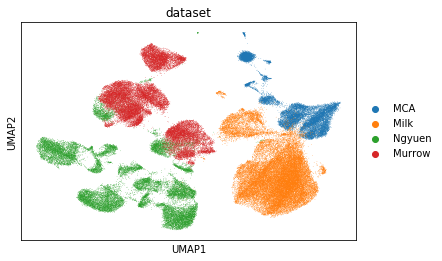

In [24]:
sc.pp.neighbors(combined_adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color="dataset")

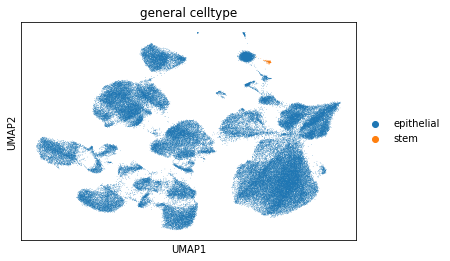

In [25]:
sc.pl.umap(combined_adata, color="general celltype")

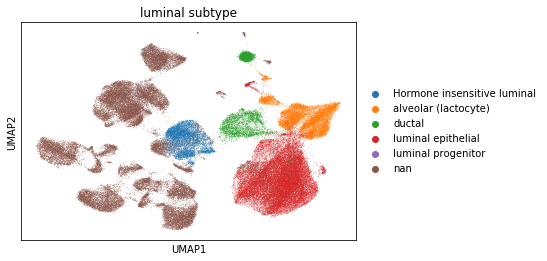

In [26]:
sc.pl.umap(combined_adata, color="luminal subtype")

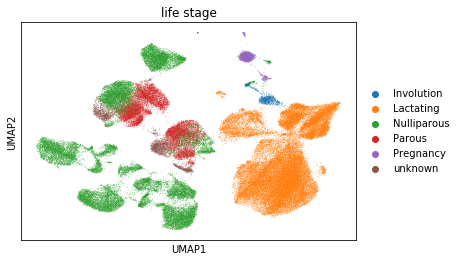

In [27]:
sc.pl.umap(combined_adata, color="life stage")

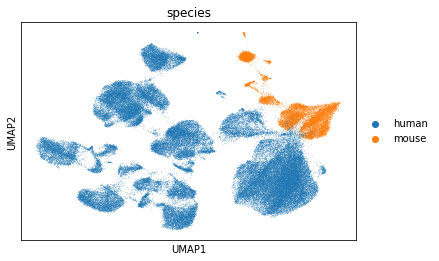

In [28]:
sc.pl.umap(combined_adata, color="species")

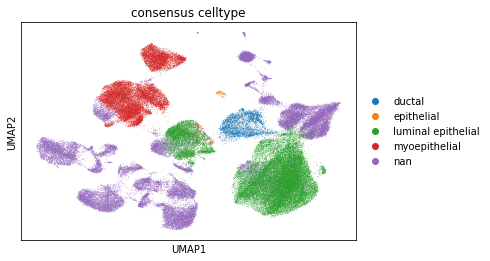

In [30]:
sc.pl.umap(combined_adata, color="consensus celltype")